In [70]:
#!pip install pydot
#!pip install visualkeras

     |████████████████████████████████| 511 kB 5.0 MB/s eta 0:00:01


In [99]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten,Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, GlobalMaxPooling2D, Conv2D, MaxPooling2D
from keras.utils import np_utils
from keras.utils.vis_utils import plot_model
import visualkeras

from sklearn.metrics import confusion_matrix
import seaborn as sns
from seaborn import heatmap

import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt

from keras.datasets import mnist

In [16]:
(train_X, train_y), (test_X, test_y) = mnist.load_data()

In [19]:
train_y[59959]

6

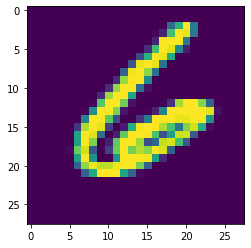

In [18]:
plt.imshow(train_X[59959])
plt.show()

In [12]:
len(train_X)

60000

In [20]:
train_X.shape

(60000, 28, 28)

In [35]:
X_train=train_X
Y_train=train_y

In [49]:
X_test=test_X
Y_test=test_y

In [39]:
train_y

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

In [36]:
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
#X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)

X_train = X_train.astype('float32')
#X_test = X_test.astype('float32')

X_train /= 255
#X_test /= 255

Y_train = np_utils.to_categorical(Y_train, 10)

In [38]:
Y_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]], dtype=float32)

In [40]:
X_train.shape

(60000, 28, 28, 1)

In [27]:
# Moving right along, let's establish our model.
model = Sequential()

# We also add the first layer, the input layer.
model.add(Conv2D(32, (3, 3), strides = (1, 1), 
                 activation = "relu", input_shape = (28, 28, 1)))

model.add(Conv2D(32, (3, 3), activation = 'relu')) # The first hidden layer.
model.add(MaxPooling2D(pool_size = (2, 2))) # The first pooling layer. 
model.add(Dropout(0.25)) # First dropout layer.
model.add(Conv2D(16, (2, 2), activation = "relu")) # The second hidden layer.
model.add(Dropout(0.15)) # Second dropout layer.
model.add(Flatten())

# We add a fully connected layer, dropout one last time, and then have our final layer.
model.add(Dense(128, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "sigmoid"))
model.compile(loss = "categorical_crossentropy",
              optimizer = "adam",
              metrics = ["accuracy"])

In [44]:
tf.config.experimental_run_functions_eagerly(True)

Instructions for updating:
Use `tf.config.run_functions_eagerly` instead of the experimental version.


In [45]:
model.fit(X_train, Y_train,validation_split=0.2,epochs=3)

Epoch 1/3
   2/1500 [..............................] - ETA: 38s - loss: 2.2959 - accuracy: 0.1719

/Users/pimawatmingkwan/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/data/ops/dataset_ops.py:3349: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


1500/1500 [==============================] - 112s 74ms/step - loss: 0.3170 - accuracy: 0.9087 - val_loss: 0.0595 - val_accuracy: 0.9822
Epoch 2/3
1500/1500 [==============================] - 148s 99ms/step - loss: 0.1097 - accuracy: 0.9680 - val_loss: 0.0449 - val_accuracy: 0.9862
Epoch 3/3
1500/1500 [==============================] - 156s 104ms/step - loss: 0.0855 - accuracy: 0.9751 - val_loss: 0.0369 - val_accuracy: 0.9886


In [46]:
[print(i.shape, i.dtype) for i in model.inputs]
[print(o.shape, o.dtype) for o in model.outputs]
[print(l.name, l.input_shape, l.dtype) for l in model.layers]

(None, 28, 28, 1) <dtype: 'float32'>
(None, 10) <dtype: 'float32'>
conv2d (None, 28, 28, 1) float32
conv2d_1 (None, 26, 26, 32) float32
max_pooling2d (None, 24, 24, 32) float32
dropout (None, 12, 12, 32) float32
conv2d_2 (None, 12, 12, 32) float32
dropout_1 (None, 11, 11, 16) float32
flatten (None, 11, 11, 16) float32
dense_6 (None, 1936) float32
dropout_2 (None, 128) float32
dense_7 (None, 128) float32


[None, None, None, None, None, None, None, None, None, None]

In [47]:
# This evaluates the model on the training data. 
# We have no test data from Kaggle, so this is the next best thing.
score = model.evaluate(X_train, Y_train, verbose = 1)
# These are the loss and accuracy values. Ask someone who knows what they're doing what that means.
score

1875/1875 [==============================] - 28s 15ms/step - loss: 0.0296 - accuracy: 0.9909


[0.029641199856996536, 0.9908999800682068]

In [50]:
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)
X_test = X_test.astype('float32')
X_test /= 255

In [51]:
# Creates a numpy array of our algorithm's predictions on the test dataset.
predictions = model.predict_classes(X_test, verbose = 1)

# And then this exports our predictions to a csv file.
# Note that the submission suggestion was 1-indexed. Ugh.
df = pd.DataFrame({"ImageId" : range(1,len(predictions) + 1),
                   "Label" : predictions})
df.to_csv("predictions.csv", index = False)
# We could then submit that .csv to the Kaggle competition.

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
313/313 [==============================] - 2s 6ms/step


In [52]:
df

,ImageId,Label
0,1,7
1,2,2
2,3,1
3,4,0
4,5,4
...,...,...
9995,9996,2
9996,9997,3
9997,9998,4
9998,9999,5


In [94]:
len(test_y.tolist())

10000

In [95]:
len(predictions.tolist())

10000

In [100]:
confusion_matrix = confusion_matrix(test_y, predictions)

In [104]:
confusion_matrix

array([[ 978,    0,    0,    0,    0,    0,    0,    1,    1,    0],
       [   2, 1124,    2,    2,    0,    2,    1,    0,    2,    0],
       [   4,    1, 1021,    1,    0,    0,    0,    4,    1,    0],
       [   0,    0,    1, 1003,    0,    3,    0,    2,    1,    0],
       [   0,    0,    0,    0,  975,    0,    1,    0,    1,    5],
       [   0,    0,    0,    5,    0,  883,    2,    1,    0,    1],
       [   8,    3,    0,    1,    1,    5,  939,    0,    1,    0],
       [   0,    2,   10,    2,    0,    1,    0, 1010,    2,    1],
       [   4,    0,    1,    1,    0,    0,    0,    1,  966,    1],
       [   3,    1,    0,    1,    6,    3,    0,    6,   12,  977]])

<function matplotlib.pyplot.show(*args, **kw)>

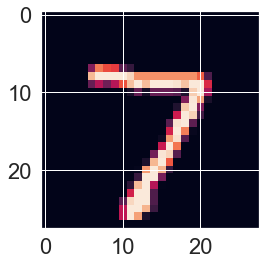

In [91]:
plt.imshow(test_X[0])
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

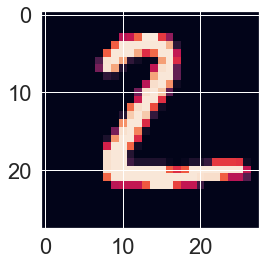

In [92]:
plt.imshow(test_X[1])
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

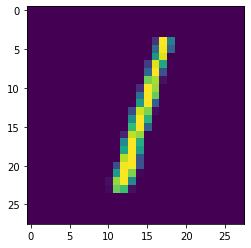

In [61]:
plt.imshow(test_X[2])
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

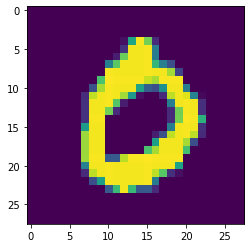

In [62]:
plt.imshow(test_X[3])
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

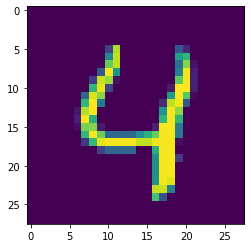

In [63]:
plt.imshow(test_X[4])
plt.show

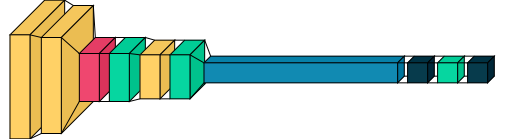

In [72]:
visualkeras.layered_view(model)

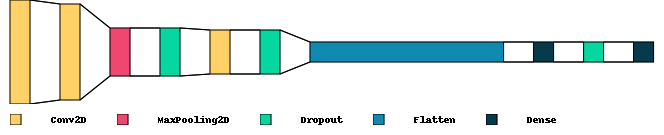

In [75]:
visualkeras.layered_view(model, legend=True, draw_volume=False,spacing=30)